In [1]:
from pathlib import Path

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import metpy.calc as mcalc
from metpy.units import units
import numpy as np
import xarray as xr

from mcs_prime.era5_calc import ERA5Calc

# ERA5 TCWV as calculated by ECMWF in ERA5

In [2]:
an_sfc_dir = Path('/badc/ecmwf-era5/data/oper/an_sfc/2020/06')  # June 2020

In [3]:
e5tcwv_paths = sorted(an_sfc_dir.glob('*/*tcwv.nc'))

In [5]:
e5tcwv1m = xr.open_mfdataset(e5tcwv_paths).tcwv

In [6]:
e5tcwv1m.values.max()  # 1-month max

86.499405

In [7]:
e5tcwv = e5tcwv1m.isel(time=0) # 0000 1/6/2020

# Equivalent TCWV calc using q, t, p

In [8]:
e5c = ERA5Calc('/gws/nopw/j04/mcs_prime/mmuetz/data/ERA5/ERA5_L137_model_levels_table.csv')

In [9]:
lnsp = xr.open_dataarray('/badc/ecmwf-era5/data/oper/an_ml/2020/06/01/ecmwf-era5_oper_an_ml_202006010000.lnsp.nc')
p = e5c.calc_pressure(lnsp[0].values)

In [10]:
t = xr.open_dataarray('/badc/ecmwf-era5/data/oper/an_ml/2020/06/01/ecmwf-era5_oper_an_ml_202006010000.t.nc')[0]
q = xr.open_dataarray('/badc/ecmwf-era5/data/oper/an_ml/2020/06/01/ecmwf-era5_oper_an_ml_202006010000.q.nc')[0]

In [11]:
def calc_tcwv(q, p):
    g = 9.81
    dp = p[1:] - p[:-1]
    return 1 / g * (q[:-1].values * dp).sum(axis=0)


In [12]:
tcwv_calc = calc_tcwv(q, p)

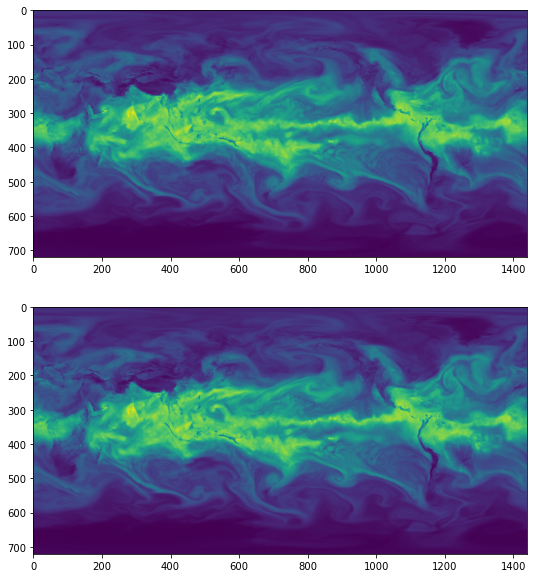

In [17]:
fig, axes = plt.subplots(2, 1)
fig.set_size_inches(10, 10)
axes[0].imshow(e5tcwv)
axes[1].imshow(tcwv_calc)

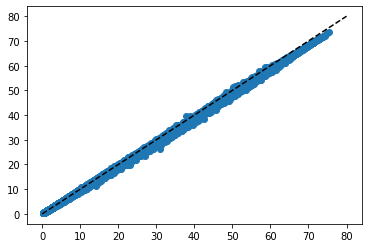

In [19]:
plt.scatter(e5tcwv.values, tcwv_calc, )
plt.plot([0, 80], [0, 80], 'k--')

# Calculate TCWV*, i.e. saturated TCWV

* Calculate q* at each pressure level, then use this for same calc as used above for TCWV.
* Make use of metpy calc.

In [22]:
mstar = mcalc.saturation_mixing_ratio(p * units('Pa'), t * units('K'))
qstar = mcalc.specific_humidity_from_mixing_ratio(mstar)

In [52]:
# IMPORTANT! Ignore upper strat.
# Including upper strat. adds huge spikes in TCWV*.
tcwvstar = calc_tcwv(qstar[60:], p[60:])  # Rem: ERA5 starts height index at TOA.
# Why 60? See figure down below that shows qstar as a function of model level.
# ML 60 == 100 hPa or so.

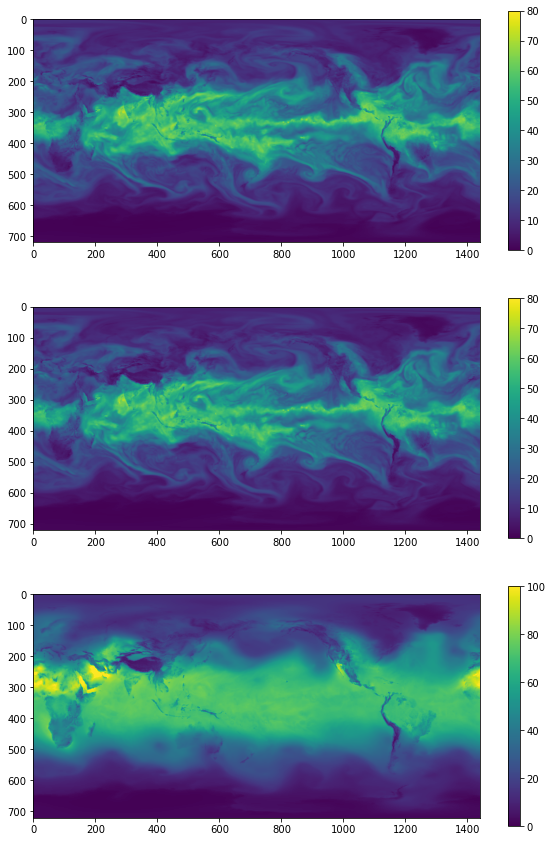

In [42]:
fig, axes = plt.subplots(3, 1)
fig.set_size_inches(10, 15)
im = axes[0].imshow(e5tcwv, vmin=0, vmax=80)
plt.colorbar(im, ax=axes[0], orientation='vertical')
im = axes[1].imshow(tcwv_calc, vmin=0, vmax=80)
plt.colorbar(im, ax=axes[1], orientation='vertical')
im = axes[2].imshow(tcwvstar, vmin=0, vmax=100)
plt.colorbar(im, ax=axes[2], orientation='vertical')

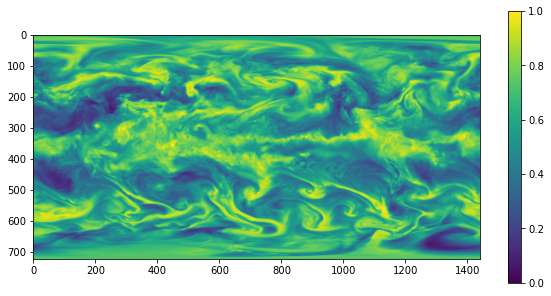

In [43]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)
im = ax.imshow(e5tcwv / tcwvstar, vmin=0, vmax=1)
plt.colorbar(im, ax=ax, orientation='vertical')

In [44]:
tcwvstar.max()

119.28452544498512

(0.0, 120.0)

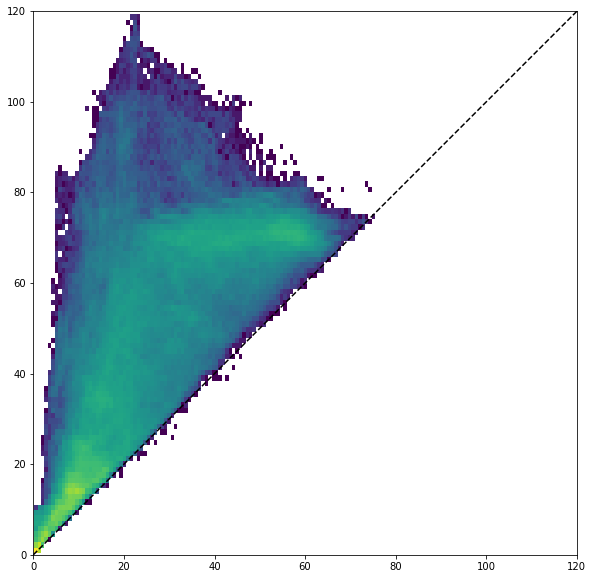

In [45]:
plt.figure(figsize=(10, 10))
plt.hist2d(e5tcwv.values.flatten(), tcwvstar.flatten(), bins=(100, 100), norm=LogNorm())
plt.plot([0, 120], [0, 120], 'k--')
plt.gca().set_aspect('equal')
plt.xlim((0, 120))
plt.ylim((0, 120))

## Same calc but including upper strat.

In [32]:
tcwvstar_full = calc_tcwv(qstar, p)

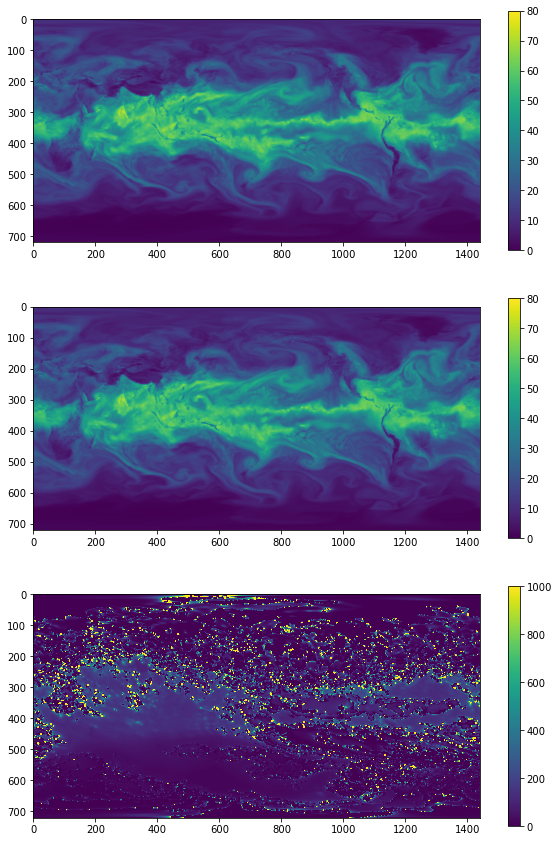

In [34]:
fig, axes = plt.subplots(3, 1)
fig.set_size_inches(10, 15)
im = axes[0].imshow(e5tcwv, vmin=0, vmax=80)
plt.colorbar(im, ax=axes[0], orientation='vertical')
im = axes[1].imshow(tcwv_calc, vmin=0, vmax=80)
plt.colorbar(im, ax=axes[1], orientation='vertical')
im = axes[2].imshow(tcwvstar_full, vmin=0, vmax=1000)
plt.colorbar(im, ax=axes[2], orientation='vertical')


In [35]:
tcwvstar_full.max()

197110.42610672434

(100000.0, 0.0)

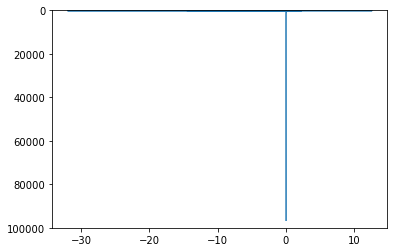

In [36]:
plt.plot(qstar.mean(axis=(1, 2)), p.mean(axis=(1, 2)))
plt.ylim(100000, 0)

Text(0, 0.5, 'p (hPa)')

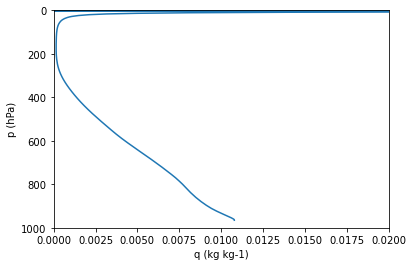

In [50]:
plt.plot(qstar.mean(axis=(1, 2)), p.mean(axis=(1, 2)) / 100)
plt.ylim(1000, 0)
plt.xlim(0, 0.02)
plt.xlabel('q (kg kg-1)')
plt.ylabel('p (hPa)')

Text(0, 0.5, 'model level (-)')

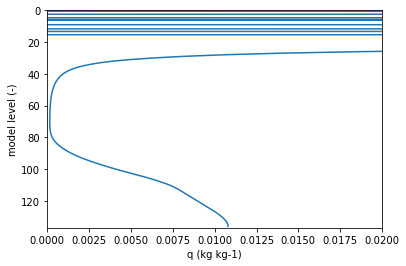

In [48]:
plt.plot(qstar.mean(axis=(1, 2)), range(137))
plt.ylim(137, 0)
plt.xlim(0, 0.02)
plt.xlabel('q (kg kg-1)')
plt.ylabel('model level (-)')

In [51]:
p[60].mean() / 100

103.68885641230126